### Measuring model robustness across training

I saved lots of checkpoints for the most recent models I trained. I want to see which checkpoint has the highest "robustness" – in this case, robustness is the lowest reidentification rate with BM25 on examples deidentified with this model.

This came to my attention when I realized an earlier checkpoint of one of my models had better robustness than a later checkpoint, even though the model appeared to keep learning after the checkpoint.

In [1]:
import sys
sys.path.append('/home/jxm3/research/deidentification/unsupervised-deidentification')

In [2]:
from dataloader import WikipediaDataModule
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

num_cpus = len(os.sched_getaffinity(0))

dm = WikipediaDataModule(
    document_model_name_or_path="roberta-base",
    profile_model_name_or_path="google/tapas-base",
    max_seq_length=128,
    dataset_name='wiki_bio',
    dataset_train_split='train[:1024]', # not used in this notebook
    dataset_val_split='val[:20%]',
    dataset_version='1.2.0',
    word_dropout_ratio=0.0,
    word_dropout_perc=0.0,
    num_workers=1,
    train_batch_size=64,
    eval_batch_size=64
)
dm.setup("fit")

Initializing WikipediaDataModule with num_workers = 1 and mask token `<mask>`
loading wiki_bio[1.2.0] split train[:1024]


Using custom data configuration default
Reusing dataset wiki_bio (/home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da)
Using custom data configuration default


loading wiki_bio[1.2.0] split val[:20%]


Reusing dataset wiki_bio (/home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da)
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da/cache-793b771e10f80bbe.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da/cache-7d07543b6205ca87.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da/cache-912d45fbf560a15e.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da/cache-4731c171b2d92df3.arrow
Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/wik

## 2. Define attack in TextAttack 

In [4]:
import textattack

### (a) Beam search + replace with `[MASK]`

In [5]:
class WordSwapSingleWord(textattack.transformations.word_swap.WordSwap):
    """Takes a sentence and transforms it by replacing with a single fixed word.
    """
    single_word: str
    def __init__(self, single_word: str = "?", **kwargs):
        super().__init__(**kwargs)
        self.single_word = single_word

    def _get_replacement_words(self, _word: str):
        return [self.single_word]

transformation = WordSwapSingleWord(single_word=dm.document_tokenizer.mask_token)
transformation(textattack.shared.AttackedText("Hello my name is Jack"))

[<AttackedText "<mask> my name is Jack">,
 <AttackedText "Hello <mask> name is Jack">,
 <AttackedText "Hello my <mask> is Jack">,
 <AttackedText "Hello my name <mask> Jack">,
 <AttackedText "Hello my name is <mask>">]

### (b) "Attack success" as fullfilment of the metric

In [6]:
from typing import List
import torch

class ChangeClassificationToBelowTopKClasses(textattack.goal_functions.ClassificationGoalFunction):
    k: int
    def __init__(self, *args, k: int = 1, **kwargs):
        self.k = k
        super().__init__(*args, **kwargs)

    def _is_goal_complete(self, model_output, _):
        original_class_score = model_output[self.ground_truth_output]
        num_better_classes = (model_output > original_class_score).sum()
        return num_better_classes >= self.k

    def _get_score(self, model_output, _):
        return 1 - model_output[self.ground_truth_output]
    
    
    """have to reimplement the following method to change the precision on the sum-to-one condition."""
    def _process_model_outputs(self, inputs, scores):
        """Processes and validates a list of model outputs.
        This is a task-dependent operation. For example, classification
        outputs need to have a softmax applied.
        """
        # Automatically cast a list or ndarray of predictions to a tensor.
        if isinstance(scores, list):
            scores = torch.tensor(scores)

        # Ensure the returned value is now a tensor.
        if not isinstance(scores, torch.Tensor):
            raise TypeError(
                "Must have list, np.ndarray, or torch.Tensor of "
                f"scores. Got type {type(scores)}"
            )

        # Validation check on model score dimensions
        if scores.ndim == 1:
            # Unsqueeze prediction, if it's been squeezed by the model.
            if len(inputs) == 1:
                scores = scores.unsqueeze(dim=0)
            else:
                raise ValueError(
                    f"Model return score of shape {scores.shape} for {len(inputs)} inputs."
                )
        elif scores.ndim != 2:
            # If model somehow returns too may dimensions, throw an error.
            raise ValueError(
                f"Model return score of shape {scores.shape} for {len(inputs)} inputs."
            )
        elif scores.shape[0] != len(inputs):
            # If model returns an incorrect number of scores, throw an error.
            raise ValueError(
                f"Model return score of shape {scores.shape} for {len(inputs)} inputs."
            )
        elif not ((scores.sum(dim=1) - 1).abs() < 1e-4).all():
            # Values in each row should sum up to 1. The model should return a
            # set of numbers corresponding to probabilities, which should add
            # up to 1. Since they are `torch.float` values, allow a small
            # error in the summation.
            scores = torch.nn.functional.softmax(scores, dim=1)
            if not ((scores.sum(dim=1) - 1).abs() < 1e-4).all():
                raise ValueError("Model scores do not add up to 1.")
        return scores.cpu()


## (c) Model wrapper that computes similarities of input documents with validation profiles

In [7]:
import transformers
from model.model import Model

class MyModelWrapper(textattack.models.wrappers.ModelWrapper):
    model: Model
    tokenizer: transformers.AutoTokenizer
    profile_embeddings: torch.Tensor
    max_seq_length: int
    
    def __init__(self, model: Model, tokenizer: transformers.AutoTokenizer, max_seq_length: int = 128):
        self.model = model
        self.model.eval()
        self.tokenizer = tokenizer
        self.profile_embeddings = torch.tensor(model.val_profile_embeddings)
        self.max_seq_length = max_seq_length
                 
    def to(self, device):
        self.model.to(device)
        self.profile_embeddings.to(device)
        return self # so semantics `model = MyModelWrapper().to('cuda')` works properly

    def __call__(self, text_input_list: List[str], batch_size=32):
        model_device = next(self.model.parameters()).device
        
        doc_tokenized = self.tokenizer.batch_encode_plus(
            text_input_list,
            max_length=self.max_seq_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        )
        doc_tokenized = {f'document__{k}': v for k,v in doc_tokenized.items()}
        with torch.no_grad():
            document_embeddings = self.model.forward_document(batch=doc_tokenized, document_type='document')
            document_to_profile_logits = document_embeddings @ self.profile_embeddings.T.to(model_device)
            document_to_profile_probs = torch.nn.functional.softmax(
                document_to_profile_logits, dim=-1
            )
        assert document_to_profile_probs.shape == (len(text_input_list), len(self.profile_embeddings))
        return document_to_profile_probs
            

## (d) Dataset that loads Wikipedia documents with names as labels

Oh, and it filters out examples that are too long.

In [8]:
from typing import Tuple

from collections import OrderedDict

import datasets

class WikiDataset(textattack.datasets.Dataset):
    dataset: datasets.Dataset
    
    def __init__(self, dm: WikipediaDataModule):
        self.shuffled = True
        self.dataset = [ex for ex in dm.val_dataset]
        self.label_names = list(dm.val_dataset['name'])
    
    def __len__(self) -> int:
        return len(self.dataset)
    
    def __getitem__(self, i: int) -> Tuple[OrderedDict, int]:
        input_dict = OrderedDict([
            ('document', self.dataset[i]['document'])
        ])
        return input_dict, self.dataset[i]['text_key_id']
        

## 3. Run attack once

In [9]:
class MaxNumWordsModified(textattack.constraints.PreTransformationConstraint):
    def __init__(self, max_num_words: int):
        self.max_num_words = max_num_words

    def _get_modifiable_indices(self, current_text):
        """Returns the word indices in current_text which are able to be
        modified."""

        if len(current_text.attack_attrs["modified_indices"]) >= self.max_num_words:
            return set()
        else:
            return set(range(len(current_text.words)))

    def extra_repr_keys(self):
        return ["max_num_words"]

In [10]:
from textattack.loggers import CSVLogger
from textattack.shared import AttackedText

import pandas as pd
class CustomCSVLogger(CSVLogger):
    """Logs attack results to a CSV."""

    def log_attack_result(self, result: textattack.goal_function_results.ClassificationGoalFunctionResult):
        # TODO print like 'mask1', 'mask2',
        original_text, perturbed_text = result.diff_color(self.color_method)
        original_text = original_text.replace("\n", AttackedText.SPLIT_TOKEN)
        perturbed_text = perturbed_text.replace("\n", AttackedText.SPLIT_TOKEN)
        result_type = result.__class__.__name__.replace("AttackResult", "")
        row = {
            "original_person": result.original_result._processed_output[0],
            "original_text": original_text,
            "original_text_id_bm25": bm25.get_scores(result.original_result.attacked_text.text.split()).argmax(),
            "perturbed_person": result.perturbed_result._processed_output[0],
            "perturbed_text": perturbed_text,
            "perturbed_text_id_bm25": bm25.get_scores(result.perturbed_result.attacked_text.text.split()).argmax(),
            "original_score": result.original_result.score,
            "perturbed_score": result.perturbed_result.score,
            "original_output": result.original_result.output,
            "perturbed_output": result.perturbed_result.output,
            "ground_truth_output": result.original_result.ground_truth_output,
            "num_queries": result.num_queries,
            "result_type": result_type,
        }
        self.df = pd.concat([self.df, pd.DataFrame([row])], ignore_index=True)

In [11]:
from typing import List

from nltk.corpus import stopwords
from rank_bm25 import BM25Okapi

eng_stopwords = stopwords.words('english')
from tqdm.auto import tqdm
tqdm.pandas()


def get_words_from_doc(s: List[str]) -> List[str]:
    words = s.split()
    return [w for w in words if not w in eng_stopwords]

def make_table_str(ex):
    ex['table_str'] = (
        ' '.join(ex['input_text']['table']['column_header'] + ex['input_text']['table']['content'])
    )
    return ex

prof_data = dm.val_dataset.map(make_table_str)
profile_corpus = prof_data['table_str']

tokenized_profile_corpus = [
    get_words_from_doc(prof) for prof in profile_corpus
]

bm25 = BM25Okapi(tokenized_profile_corpus)

Loading cached processed dataset at /home/jxm3/.cache/huggingface/datasets/wiki_bio/default/1.2.0/c05ce066e9026831cd7535968a311fc80f074b58868cfdffccbc811dff2ab6da/cache-92ac1b8192dcf3bb.arrow


In [ ]:
import numpy as np
from tqdm import tqdm

def precompute_profile_embeddings(dm, my_model):
    my_model.profile_model.cuda()
    my_model.profile_model.eval()
    my_model.profile_embed.cuda()
    my_model.profile_embed.eval()

    my_model.val_profile_embeddings = np.zeros((len(dm.val_dataset), my_model.shared_embedding_dim))
    for val_batch in tqdm(dm.val_dataloader()[0], desc="Precomputing val embeddings", colour="green", leave=False):
        with torch.no_grad():
            profile_embeddings = my_model.forward_profile(batch=val_batch)
        my_model.val_profile_embeddings[val_batch["text_key_id"]] = profile_embeddings.cpu()
    my_model.val_profile_embeddings = torch.tensor(my_model.val_profile_embeddings, dtype=torch.float32)

# precompute_profile_embeddings(model)

In [ ]:
from model import CoordinateAscentModel

import copy
import glob
# 
#  Initialize attack
# 

from textattack import Attack
from textattack.constraints.pre_transformation import MaxWordIndexModification, RepeatModification

from tqdm import tqdm 
from textattack.attack_results import SuccessfulAttackResult
from textattack import Attacker
from textattack import AttackArgs

dataset = WikiDataset(dm)

for idx in range(len(dataset.dataset)):
    words = dataset.dataset[idx]['document'].split(' ')
    if len(words) > 100:
        words = words[:100]
        dataset.dataset[idx]['document'] = ' '.join(words)


results = []
dfs = []
for checkpoint_epoch in [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60]:
    dm = WikipediaDataModule(
        document_model_name_or_path="roberta-base",
        profile_model_name_or_path="google/tapas-base",
        max_seq_length=128,
        dataset_name='wiki_bio',
        dataset_train_split='train[:1024]', # not used in this notebook
        dataset_val_split='val[:20%]',
        dataset_version='1.2.0',
        word_dropout_ratio=0.0,
        word_dropout_perc=0.0,
        num_workers=1,
        train_batch_size=64,
        eval_batch_size=64
    )
    dm.setup("fit")
    
    print(f'*** checkpoint_epoch = {checkpoint_epoch} ***')
       
    checkpoint_path = glob.glob(f'../saves/ca__roberta__tapas__dropout_-1.0_1.0_0.0__e3072__ls0.1/*4*/*745/checkpoints/*epoch={checkpoint_epoch}-*idf*.ckpt')[0]
    model = CoordinateAscentModel.load_from_checkpoint(
        checkpoint_path
    )
    model.load_from_checkpoint(checkpoint_path)
    model.cuda()
    precompute_profile_embeddings(dm, model)
    
    
    model_wrapper = MyModelWrapper(model=model, tokenizer=dm.document_tokenizer)
    model_wrapper.to('cuda')

    goal_function = ChangeClassificationToBelowTopKClasses(model_wrapper, k=1)
    constraints = [
        RepeatModification(),
        MaxWordIndexModification(max_length=dm.max_seq_length),
        MaxNumWordsModified(max_num_words=50)
    ]
    transformation = WordSwapSingleWord(single_word=dm.document_tokenizer.mask_token)
    search_method = textattack.search_methods.GreedyWordSwapWIR(unk_token=dm.document_tokenizer.mask_token)
    
    attack = Attack(
        goal_function, constraints, transformation, search_method
    )
    attack_args = AttackArgs(num_examples=100, disable_stdout=True)
    attacker = Attacker(attack, dataset, attack_args)

    results_iterable = attacker.attack_dataset()

    logger = CustomCSVLogger(color_method='html')

    # 
    # Run attack
    # 
    from tqdm import tqdm
    for result in results_iterable:
        logger.log_attack_result(result)

    # 
    # Collect results
    succ_df = logger.df[logger.df['result_type'] == 'Successful']
    bmid_rate = (succ_df['original_output'] == succ_df['perturbed_text_id_bm25']).mean()
    num_failures = (logger.df['result_type'] == 'Failed').sum()
    num_successes = (logger.df['result_type'] == 'Successful').sum()
    num_skipped = (logger.df['result_type'] == 'Skipped').sum()
    num_queries = succ_df['num_queries'].mean()

    print('\tBMID rate:', bmid_rate)

    dfs.append(copy.copy(logger.df))
    results.append([
        checkpoint_epoch, checkpoint_path,
        bmid_rate, num_queries,
        num_failures, num_successes, num_skipped,
    ])

<AxesSubplot:xlabel='checkpoint_epoch'>

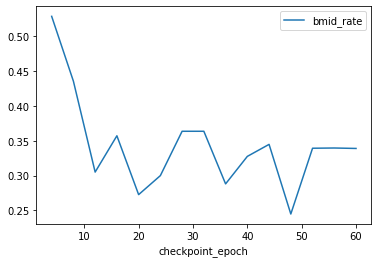

In [35]:
import pandas as pd
results_df = pd.DataFrame(
    results,
    columns=[
        'checkpoint_epoch', 'checkpoint_path','bmid_rate', 'num_queries',
        'num_failures', 'num_successes', 'num_skipped'
    ]
)
results_df.plot(x='checkpoint_epoch', y='bmid_rate')